In [12]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

import time
from collections import deque, namedtuple
import random
import gymnasium as gym
import numpy as np
import PIL.Image

import imageio
import base64
import IPython

# set the seed for the random number generator
random.seed(42)
torch.manual_seed(42)

In [13]:

GAMMA = 0.995             # discount factor
ALPHA = 1e-3              # learning rate
NUM_STEPS_FOR_UPDATE = 4  # perform a learning update

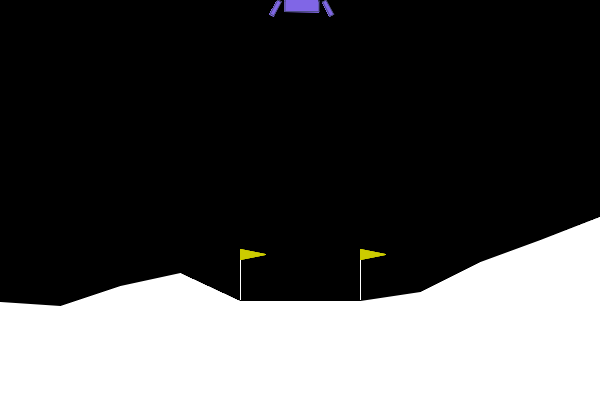

In [14]:
env = gym.make('LunarLander-v3', render_mode='rgb_array')
env.reset()
PIL.Image.fromarray(env.render())

In [15]:
state_size = env.observation_space.shape
num_actions = env.action_space.n

print('State Shape:', state_size)
print('Number of actions:', num_actions)

State Shape: (8,)
Number of actions: 4


In [16]:
# Reset the environment and get the initial state.
initial_state, _ = env.reset()
print(initial_state)

[ 2.8114318e-04  1.3991367e+00  2.8460810e-02 -5.2370918e-01
 -3.1898098e-04 -6.4467629e-03  0.0000000e+00  0.0000000e+00]


In [17]:
# helper function to create and embed a video

def create_and_embed_video(env_name, q_network, episode, fps=30, max_steps_per_episode=1000):
    env = gym.make(env_name, render_mode='rgb_array')
    filename = f"{env_name}_episode_{episode}.mp4"

    def create_video(env, q_network, fps=30):
        with imageio.get_writer(filename, fps=fps) as video:
            done = False
            state, _ = env.reset()
            frame = env.render()
            video.append_data(frame)
            steps = 0   
            while not done and steps < max_steps_per_episode:
                steps += 1
                # Convert state to float32 numpy array before expanding dimensions
                state = np.array(state, dtype=np.float32)
                state = np.expand_dims(state, axis=0)
                state = torch.tensor(state, dtype=torch.float32)
                with torch.no_grad():  # Add this to prevent gradient computation
                    q_values = q_network(state)
                action = np.argmax(q_values.numpy()[0])
                state, reward, done, truncated, _ = env.step(action)
                frame = env.render()
                video.append_data(frame)

    def embed_mp4(filename):
        """Embeds an mp4 file in the notebook."""
        video = open(filename, 'rb').read()
        b64 = base64.b64encode(video)
        tag = '''
        <video width="840" height="480" controls>
        <source src="data:video/mp4;base64,{0}" type="video/mp4">
        Your browser does not support the video tag.
        </video>'''.format(b64.decode())
        return IPython.display.HTML(tag)

    create_video(env, q_network, fps)
    return embed_mp4(filename)

Initial State: [0.000 1.399 0.028 -0.524 -0.000 -0.006 0.000 0.000]
Action: 1
Next State: [0.000 1.387 0.020 -0.549 0.001 0.028 0.000 0.000]
Reward Received: -1.3438501604925353
Episode Terminated: False
Truncated: False
Info: {}


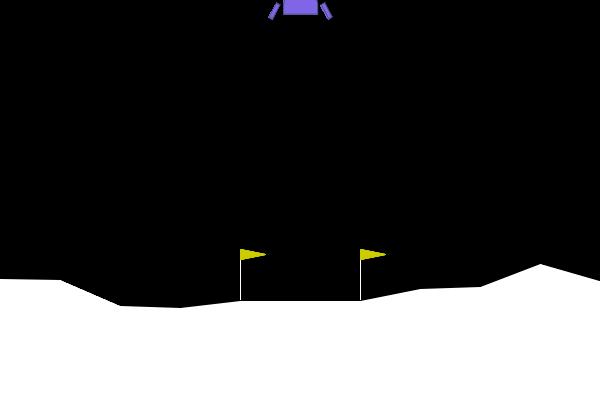

In [18]:
# Select an action
action = 1

# Run a single time step of the environment's dynamics with the given action.
new_state, reward, done, truncated, info = env.step(action)

with np.printoptions(formatter={'float': '{:.3f}'.format}):
    print("Initial State:", initial_state)
    print("Action:", action)
    print("Next State:", new_state)
    print("Reward Received:", reward)
    print("Episode Terminated:", done)
    print("Truncated:", truncated)
    print("Info:", info)
PIL.Image.fromarray(env.render())


## Build model

build a torch model:
* An `Input` layer that takes `state_size` as input.

* A `Dense` layer with `64` units and a `relu` activation function.

* A `Dense` layer with `64` units and a `relu` activation function.

* A `Dense` layer with `num_actions` units and a `linear` activation function. This will be the output layer of our network.

In [19]:
class Model(nn.Module):
    def __init__(self, state_size, num_actions):
        super(Model, self).__init__()
        self.fc1 = nn.Linear(state_size[0], 64)
        self.fc2 = nn.Linear(64, 64)
        self.fc3 = nn.Linear(64, num_actions)

    def forward(self, state):
        x = F.relu(self.fc1(state))
        x = F.relu(self.fc2(x))
        return self.fc3(x)

policy_model = Model(state_size, num_actions)
optimizer = optim.Adam(policy_model.parameters(), lr=0.001)
loss_fn = nn.MSELoss()

# make a target model that is copied from the policy model
target_model = Model(state_size, num_actions)

# copy the weights from the policy model to the target model
target_model.load_state_dict(policy_model.state_dict())

print(policy_model)


Model(
  (fc1): Linear(in_features=8, out_features=64, bias=True)
  (fc2): Linear(in_features=64, out_features=64, bias=True)
  (fc3): Linear(in_features=64, out_features=4, bias=True)
)


In [20]:
# Store experiences as named tuples
Experience = namedtuple("Experience", field_names=[
                        "state", "action", "reward", "next_state", "done"])


In [21]:
MEMORY_SIZE = 100_000     # size of memory buffer
# implement the experience replay buffer
class ReplayBuffer:
    def __init__(self, capacity):
        self.buffer = deque(maxlen=capacity)

    def add(self, experience):
        self.buffer.append(experience)

    def sample(self, batch_size):
        return random.sample(self.buffer, batch_size)

# create a replay buffer
replay_buffer = ReplayBuffer(capacity=MEMORY_SIZE)

# add a random experience to the buffer
replay_buffer.add(Experience(state=initial_state, action=action,
                             reward=reward, next_state=new_state, done=done))

In [22]:

# Define epsilon-greedy action selection
def select_action(state, model, epsilon=0.1):
    if random.random() < epsilon:
        return random.randint(0, num_actions-1)

    with torch.no_grad():
        state = torch.FloatTensor(state).unsqueeze(0)
        q_values = model(state)
        return q_values.argmax().item()


# Define training function
def train_step(experiences, policy_model, target_model, optimizer, batch_size=64):
    # Sample random batch of experiences
    batch = random.sample(experiences, batch_size)

    # Convert batch of experiences to separate arrays - with optimization
    states = torch.FloatTensor(np.array([exp.state for exp in batch]))
    actions = torch.LongTensor([exp.action for exp in batch])
    rewards = torch.FloatTensor([exp.reward for exp in batch])
    next_states = torch.FloatTensor(
        np.array([exp.next_state for exp in batch]))
    dones = torch.FloatTensor([exp.done for exp in batch])

    # Compute current Q values
    current_q_values = policy_model(states).gather(1, actions.unsqueeze(1))

    # Compute next Q values
    with torch.no_grad():
        next_q_values = target_model(next_states).max(1)[0]

        # Compute target Q values
        target_q_values = rewards + (GAMMA * next_q_values * (1 - dones))
        target_q_values = target_q_values.unsqueeze(1)

    # Compute loss
    loss = loss_fn(current_q_values, target_q_values)

    # Optimize the model
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    return loss.item()


# Main training loop
num_episodes = 1000
batch_size = 64
epsilon_start = 1.0
epsilon_end = 0.01
epsilon_decay = 0.995
max_steps_per_episode = 1000
epsilon = epsilon_start
acc_rewards = []
min_experiences = 200

for episode in range(num_episodes):
    state, _ = env.reset()
    acc_reward = 0
    done = False
    truncated = False
    steps = 0
    # Update target model once per two episodes
    if   episode % 2 == 0:
        target_model.load_state_dict(policy_model.state_dict())
    if episode == 0 or (episode + 1) % 100 == 0:
        video = create_and_embed_video(
            'LunarLander-v3', policy_model, episode=episode)
    while not (done or truncated) and steps < max_steps_per_episode:
        # Select action
        action = select_action(state, policy_model, epsilon)

        # Take action
        next_state, reward, done, truncated, _ = env.step(action)

        # Store experience
        experience = Experience(state, action, reward, next_state, done)
        replay_buffer.add(experience)

        # Update state and score
        state = next_state
        acc_reward += reward
        steps += 1
        # Train model if enough experiences are collected
        if len(replay_buffer.buffer) >= min_experiences:
            loss = train_step(replay_buffer.buffer, policy_model, target_model,
                              optimizer, batch_size)


    # Decay epsilon
    epsilon = max(epsilon_end, epsilon * epsilon_decay)

    # Store accumulated reward
    acc_rewards.append(acc_reward)

    # Print progress
    if (episode + 1) % 10 == 0:
        avg_acc_reward = np.mean(acc_rewards[-10:])
        print(
            f"Episode {episode + 1}, Average accumulated reward: {avg_acc_reward:.2f}, Epsilon: {epsilon:.2f}")

IMAGEIO FFMPEG_WRITER WARNING: input image is not divisible by macro_block_size=16, resizing from (600, 400) to (608, 400) to ensure video compatibility with most codecs and players. To prevent resizing, make your input image divisible by the macro_block_size or set the macro_block_size to 1 (risking incompatibility).


Episode 10, Average accumulated reward: -157.65, Epsilon: 0.95
Episode 20, Average accumulated reward: -125.43, Epsilon: 0.90
Episode 30, Average accumulated reward: -168.85, Epsilon: 0.86
Episode 40, Average accumulated reward: -183.56, Epsilon: 0.82
Episode 50, Average accumulated reward: -84.14, Epsilon: 0.78
Episode 60, Average accumulated reward: -79.99, Epsilon: 0.74
Episode 70, Average accumulated reward: -83.37, Epsilon: 0.70
Episode 80, Average accumulated reward: -62.59, Epsilon: 0.67
Episode 90, Average accumulated reward: -58.55, Epsilon: 0.64


IMAGEIO FFMPEG_WRITER WARNING: input image is not divisible by macro_block_size=16, resizing from (600, 400) to (608, 400) to ensure video compatibility with most codecs and players. To prevent resizing, make your input image divisible by the macro_block_size or set the macro_block_size to 1 (risking incompatibility).


Episode 100, Average accumulated reward: -58.62, Epsilon: 0.61
Episode 110, Average accumulated reward: -48.12, Epsilon: 0.58
Episode 120, Average accumulated reward: -36.94, Epsilon: 0.55
Episode 130, Average accumulated reward: -63.14, Epsilon: 0.52
Episode 140, Average accumulated reward: -100.65, Epsilon: 0.50
Episode 150, Average accumulated reward: -29.56, Epsilon: 0.47
Episode 160, Average accumulated reward: -51.93, Epsilon: 0.45
Episode 170, Average accumulated reward: -57.91, Epsilon: 0.43
Episode 180, Average accumulated reward: -40.28, Epsilon: 0.41
Episode 190, Average accumulated reward: -72.07, Epsilon: 0.39


IMAGEIO FFMPEG_WRITER WARNING: input image is not divisible by macro_block_size=16, resizing from (600, 400) to (608, 400) to ensure video compatibility with most codecs and players. To prevent resizing, make your input image divisible by the macro_block_size or set the macro_block_size to 1 (risking incompatibility).


Episode 200, Average accumulated reward: -65.55, Epsilon: 0.37
Episode 210, Average accumulated reward: -83.06, Epsilon: 0.35
Episode 220, Average accumulated reward: -39.26, Epsilon: 0.33
Episode 230, Average accumulated reward: -36.04, Epsilon: 0.32
Episode 240, Average accumulated reward: -27.87, Epsilon: 0.30
Episode 250, Average accumulated reward: -60.88, Epsilon: 0.29
Episode 260, Average accumulated reward: -0.24, Epsilon: 0.27
Episode 270, Average accumulated reward: 28.20, Epsilon: 0.26
Episode 280, Average accumulated reward: 81.75, Epsilon: 0.25
Episode 290, Average accumulated reward: 78.11, Epsilon: 0.23


IMAGEIO FFMPEG_WRITER WARNING: input image is not divisible by macro_block_size=16, resizing from (600, 400) to (608, 400) to ensure video compatibility with most codecs and players. To prevent resizing, make your input image divisible by the macro_block_size or set the macro_block_size to 1 (risking incompatibility).


Episode 300, Average accumulated reward: 134.69, Epsilon: 0.22
Episode 310, Average accumulated reward: -14.80, Epsilon: 0.21
Episode 320, Average accumulated reward: 17.86, Epsilon: 0.20
Episode 330, Average accumulated reward: 128.93, Epsilon: 0.19
Episode 340, Average accumulated reward: 122.46, Epsilon: 0.18
Episode 350, Average accumulated reward: 194.40, Epsilon: 0.17
Episode 360, Average accumulated reward: 202.95, Epsilon: 0.16
Episode 370, Average accumulated reward: 136.11, Epsilon: 0.16
Episode 380, Average accumulated reward: 170.84, Epsilon: 0.15
Episode 390, Average accumulated reward: 131.54, Epsilon: 0.14


IMAGEIO FFMPEG_WRITER WARNING: input image is not divisible by macro_block_size=16, resizing from (600, 400) to (608, 400) to ensure video compatibility with most codecs and players. To prevent resizing, make your input image divisible by the macro_block_size or set the macro_block_size to 1 (risking incompatibility).


Episode 400, Average accumulated reward: 10.00, Epsilon: 0.13
Episode 410, Average accumulated reward: 63.64, Epsilon: 0.13
Episode 420, Average accumulated reward: 142.91, Epsilon: 0.12
Episode 430, Average accumulated reward: 53.79, Epsilon: 0.12
Episode 440, Average accumulated reward: 59.06, Epsilon: 0.11
Episode 450, Average accumulated reward: 126.15, Epsilon: 0.10
Episode 460, Average accumulated reward: 149.35, Epsilon: 0.10
Episode 470, Average accumulated reward: 52.31, Epsilon: 0.09
Episode 480, Average accumulated reward: 222.56, Epsilon: 0.09
Episode 490, Average accumulated reward: 252.21, Epsilon: 0.09


IMAGEIO FFMPEG_WRITER WARNING: input image is not divisible by macro_block_size=16, resizing from (600, 400) to (608, 400) to ensure video compatibility with most codecs and players. To prevent resizing, make your input image divisible by the macro_block_size or set the macro_block_size to 1 (risking incompatibility).


Episode 500, Average accumulated reward: 168.45, Epsilon: 0.08
Episode 510, Average accumulated reward: 202.42, Epsilon: 0.08
Episode 520, Average accumulated reward: 202.31, Epsilon: 0.07
Episode 530, Average accumulated reward: 144.50, Epsilon: 0.07
Episode 540, Average accumulated reward: -37.62, Epsilon: 0.07
Episode 550, Average accumulated reward: 44.62, Epsilon: 0.06
Episode 560, Average accumulated reward: 70.55, Epsilon: 0.06
Episode 570, Average accumulated reward: -66.05, Epsilon: 0.06
Episode 580, Average accumulated reward: 78.25, Epsilon: 0.05
Episode 590, Average accumulated reward: 63.22, Epsilon: 0.05


IMAGEIO FFMPEG_WRITER WARNING: input image is not divisible by macro_block_size=16, resizing from (600, 400) to (608, 400) to ensure video compatibility with most codecs and players. To prevent resizing, make your input image divisible by the macro_block_size or set the macro_block_size to 1 (risking incompatibility).


Episode 600, Average accumulated reward: 116.10, Epsilon: 0.05
Episode 610, Average accumulated reward: 202.05, Epsilon: 0.05
Episode 620, Average accumulated reward: 214.91, Epsilon: 0.04
Episode 630, Average accumulated reward: 206.33, Epsilon: 0.04
Episode 640, Average accumulated reward: 155.15, Epsilon: 0.04
Episode 650, Average accumulated reward: 208.08, Epsilon: 0.04
Episode 660, Average accumulated reward: 210.34, Epsilon: 0.04
Episode 670, Average accumulated reward: 160.28, Epsilon: 0.03
Episode 680, Average accumulated reward: 233.67, Epsilon: 0.03
Episode 690, Average accumulated reward: 172.28, Epsilon: 0.03


IMAGEIO FFMPEG_WRITER WARNING: input image is not divisible by macro_block_size=16, resizing from (600, 400) to (608, 400) to ensure video compatibility with most codecs and players. To prevent resizing, make your input image divisible by the macro_block_size or set the macro_block_size to 1 (risking incompatibility).


Episode 700, Average accumulated reward: 190.60, Epsilon: 0.03
Episode 710, Average accumulated reward: 201.25, Epsilon: 0.03
Episode 720, Average accumulated reward: 123.89, Epsilon: 0.03
Episode 730, Average accumulated reward: 161.63, Epsilon: 0.03
Episode 740, Average accumulated reward: 211.91, Epsilon: 0.02
Episode 750, Average accumulated reward: 246.76, Epsilon: 0.02
Episode 760, Average accumulated reward: 227.25, Epsilon: 0.02
Episode 770, Average accumulated reward: 183.36, Epsilon: 0.02
Episode 780, Average accumulated reward: 241.94, Epsilon: 0.02
Episode 790, Average accumulated reward: 249.37, Epsilon: 0.02


IMAGEIO FFMPEG_WRITER WARNING: input image is not divisible by macro_block_size=16, resizing from (600, 400) to (608, 400) to ensure video compatibility with most codecs and players. To prevent resizing, make your input image divisible by the macro_block_size or set the macro_block_size to 1 (risking incompatibility).


Episode 800, Average accumulated reward: 246.63, Epsilon: 0.02
Episode 810, Average accumulated reward: 256.92, Epsilon: 0.02
Episode 820, Average accumulated reward: 155.02, Epsilon: 0.02
Episode 830, Average accumulated reward: 226.69, Epsilon: 0.02
Episode 840, Average accumulated reward: 250.70, Epsilon: 0.01
Episode 850, Average accumulated reward: 198.93, Epsilon: 0.01
Episode 860, Average accumulated reward: 247.43, Epsilon: 0.01
Episode 870, Average accumulated reward: 204.64, Epsilon: 0.01
Episode 880, Average accumulated reward: 188.53, Epsilon: 0.01
Episode 890, Average accumulated reward: 131.20, Epsilon: 0.01


IMAGEIO FFMPEG_WRITER WARNING: input image is not divisible by macro_block_size=16, resizing from (600, 400) to (608, 400) to ensure video compatibility with most codecs and players. To prevent resizing, make your input image divisible by the macro_block_size or set the macro_block_size to 1 (risking incompatibility).


Episode 900, Average accumulated reward: 250.41, Epsilon: 0.01
Episode 910, Average accumulated reward: 226.97, Epsilon: 0.01
Episode 920, Average accumulated reward: 177.53, Epsilon: 0.01
Episode 930, Average accumulated reward: 150.71, Epsilon: 0.01
Episode 940, Average accumulated reward: 37.58, Epsilon: 0.01
Episode 950, Average accumulated reward: 152.76, Epsilon: 0.01
Episode 960, Average accumulated reward: 142.14, Epsilon: 0.01
Episode 970, Average accumulated reward: 237.20, Epsilon: 0.01
Episode 980, Average accumulated reward: 254.52, Epsilon: 0.01
Episode 990, Average accumulated reward: 251.96, Epsilon: 0.01


IMAGEIO FFMPEG_WRITER WARNING: input image is not divisible by macro_block_size=16, resizing from (600, 400) to (608, 400) to ensure video compatibility with most codecs and players. To prevent resizing, make your input image divisible by the macro_block_size or set the macro_block_size to 1 (risking incompatibility).


Episode 1000, Average accumulated reward: 211.88, Epsilon: 0.01


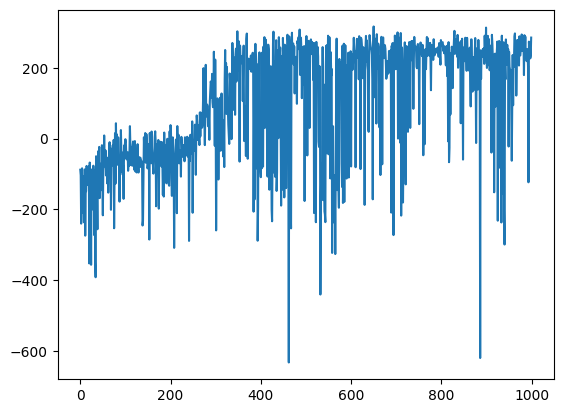

In [23]:
# plot the scores
import matplotlib.pyplot as plt
plt.plot(acc_rewards)
plt.show()
